# Fine-Tuning XLM-RoBERTa-base

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification
import pandas as pd
import thesis_utils
from datasets import Dataset
from datasets import Sequence, ClassLabel, Features, Value
from evaluate import load
import random
import numpy as np
import csv
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
comet_ml is installed but `COMET_API_KEY` is not set.


In [3]:
import warnings
warnings.filterwarnings("ignore", message=".*seems not to be NE tag.*")

### Loading the model

In [5]:
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
task = "GED-it"
batch_size = 8

### Preprocessing

In [8]:
multiged_merlin_train =  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/it_merlin_train.tsv')
multiged_merlin_dev =  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/it_merlin_dev.tsv')
#multiged_merlin_test=  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_fce_test_unlabelled.tsv')

In [9]:
print(f'Number of training sentences: {len(multiged_merlin_train)}')
print(f'Number of dev sentences: {len(multiged_merlin_dev)}\n')

print(f'Number of training tokens: {thesis_utils.token_counter(multiged_merlin_train)}')
print(f'Number of dev tokens: {thesis_utils.token_counter(multiged_merlin_dev)}')

Number of training sentences: 6394
Number of dev sentences: 758

Number of training tokens: 80335
Number of dev tokens: 9144


In [10]:
multiged_labels = ['c','i']
training_sents_idx, training_sents_tokens, training_sents_gold = thesis_utils.get_list_ids_tokens_gold(multiged_merlin_train)
dev_sents_idx, dev_sents_tokens, dev_labels= thesis_utils.get_list_ids_tokens_gold(multiged_merlin_dev)

In [11]:
training_list_dict = thesis_utils.create_list_dict(training_sents_idx, training_sents_tokens, training_sents_gold)
dev_list_dict = thesis_utils.create_list_dict(dev_sents_idx, dev_sents_tokens, dev_labels)

In [12]:
training_df = pd.DataFrame(training_list_dict)
training_dataset = Dataset.from_pandas(training_df)

dev_df = pd.DataFrame(dev_list_dict)
dev_dataset = Dataset.from_pandas(dev_df)

In [13]:
new_features = Features({
    "id_token": Sequence(Value("int64")),
    "token": Sequence(Value("string")),
    "labels": Sequence(ClassLabel(names=multiged_labels)),
})

training_dataset = training_dataset.cast(new_features)
dev_dataset = dev_dataset.cast(new_features)

Casting the dataset:   0%|          | 0/6394 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/758 [00:00<?, ? examples/s]

In [14]:
example_sentence = training_dataset['token'][3]
example_sentence_id = training_dataset['id_token'][3]
tokenized_input = tokenizer(example_sentence, truncation=True, is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [15]:
print(f'Original tokens: \n{example_sentence}')
print()
print(f'Tokens and subword tokens obtained through the AutoTokenizer of BERT (distilbert-base-uncased): \n{tokens}')
print()
print(f'Number of the original token IDs: {len(example_sentence_id)} >>>  \n{example_sentence_id}')
print()
print(f'Number of the tokens and subword token IDs: {len(tokenized_input.word_ids())} >>> \n{tokenized_input.word_ids()}')
print()
print(f'Representation of the input IDs: \n{tokenized_input['input_ids']}') 
print()
print(f'Representation of the attention mask: \n{tokenized_input['attention_mask']}')

Original tokens: 
['Questo', 'era', 'un', 'problema', 'grande', 'riguardando', 'alla', 'cosa', 'che', 'il', 'mio', 'fidanzato', 'un', 'professionista', 'del', 'tennis', '.']

Tokens and subword tokens obtained through the AutoTokenizer of BERT (distilbert-base-uncased): 
['<s>', '▁Questo', '▁era', '▁un', '▁problema', '▁grande', '▁riguarda', 'ndo', '▁alla', '▁cosa', '▁che', '▁il', '▁mio', '▁fi', 'dan', 'zato', '▁un', '▁profession', 'ista', '▁del', '▁tennis', '▁', '.', '</s>']

Number of the original token IDs: 17 >>>  
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Number of the tokens and subword token IDs: 24 >>> 
[None, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 11, 11, 12, 13, 13, 14, 15, 16, 16, None]

Representation of the input IDs: 
[0, 24667, 1615, 51, 4105, 3189, 38948, 557, 986, 6537, 290, 211, 11732, 809, 549, 104091, 51, 40124, 1035, 146, 69686, 6, 5, 2]

Representation of the attention mask: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
label_all_tokens = True

def tokenize_and_align_labels(dataset):
    tokenized_inputs = tokenizer(dataset["token"], truncation=True, is_split_into_words=True)
    labels = []
    tokenized_ids = []
    for i, label in enumerate(dataset["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
        tokenized_ids.append(word_ids)
    tokenized_inputs["t_word_id"] = tokenized_ids
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [17]:
tokenized_training_dataset = training_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dev_dataset = dev_dataset.map(tokenize_and_align_labels, batched = True)

Map:   0%|          | 0/6394 [00:00<?, ? examples/s]

Map:   0%|          | 0/758 [00:00<?, ? examples/s]

In [18]:
print(tokenized_training_dataset[3])

{'id_token': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'token': ['Questo', 'era', 'un', 'problema', 'grande', 'riguardando', 'alla', 'cosa', 'che', 'il', 'mio', 'fidanzato', 'un', 'professionista', 'del', 'tennis', '.'], 'labels': [-100, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -100], 'input_ids': [0, 24667, 1615, 51, 4105, 3189, 38948, 557, 986, 6537, 290, 211, 11732, 809, 549, 104091, 51, 40124, 1035, 146, 69686, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 't_word_id': [None, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 11, 11, 12, 13, 13, 14, 15, 16, 16, None]}


### Training

In [20]:
SEED = 1234
random.seed(SEED)   
np.random.seed(SEED)  
set_seed(SEED)  

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy="epoch",  # <- fixed here
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(multiged_labels))

/home/elisabetta/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
metric = load("seqeval")

In [23]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [multiged_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [multiged_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.327300,0.239365,0.000000,0.000000,0.000000,0.909226
2,0.212100,0.239676,0.000000,0.000000,0.000000,0.914173
3,0.178700,0.245882,0.000000,0.000000,0.000000,0.918295


/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/s

TrainOutput(global_step=2400, training_loss=0.23016774495442707, metrics={'train_runtime': 4703.9347, 'train_samples_per_second': 4.078, 'train_steps_per_second': 0.51, 'total_flos': 382358810341248.0, 'train_loss': 0.23016774495442707, 'epoch': 3.0})

### Saving the fine-tuned model

In [27]:
trainer.save_model('fine_tuned_ged_ita_xlmroberta')
trainer.tokenizer.save_pretrained('fine_tuned_ged_ita_xlmroberta')

('fine_tuned_ged_ita_xlmroberta/tokenizer_config.json',
 'fine_tuned_ged_ita_xlmroberta/special_tokens_map.json',
 'fine_tuned_ged_ita_xlmroberta/sentencepiece.bpe.model',
 'fine_tuned_ged_ita_xlmroberta/added_tokens.json',
 'fine_tuned_ged_ita_xlmroberta/tokenizer.json')

### Loading the fine-tuned model

In [29]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer
model_name = 'fine_tuned_ged_ita_xlmroberta'
model = AutoModelForTokenClassification.from_pretrained('fine_tuned_ged_ita_xlmroberta')
tokenizer = AutoTokenizer.from_pretrained('fine_tuned_ged_ita_xlmroberta', use_fast=True)

In [30]:
trainer.evaluate()

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.24588234722614288,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9182949954654135,
 'eval_runtime': 21.2657,
 'eval_samples_per_second': 35.644,
 'eval_steps_per_second': 4.467,
 'epoch': 3.0}

In [31]:
predictions, labels, _ = trainer.predict(tokenized_dev_dataset)
predictions = np.argmax(predictions, axis=2)

### Postprocessing

In [33]:
output_file_path = "predictions_xlmroberta_merlin.tsv"
dev_tokens, dev_labels, dev_predictions = thesis_utils.map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_dev_dataset, output_file_path,multiged_labels,tokenizer)

Results saved to predictions_xlmroberta_merlin.tsv


### Results and Confusion Metrix

              precision    recall    f0.5-score    support
c               0.9315    0.984369    0.94164        7933
i               0.8371    0.526012    0.74853        1211

micro avg       0.9237    0.923666    0.92367        9144
macro avg       0.8843    0.755190    0.84508        9144


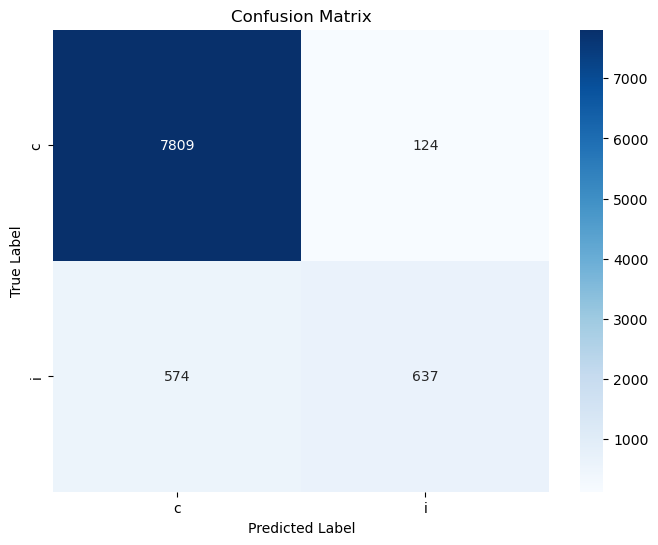

In [35]:
thesis_utils.evaluate_predictions(dev_predictions, dev_labels)